# Data Inspection
Using forward scattering information.

In [1]:
import numpy as np
import os
from scipy import *
import pandas as pd
from matplotlib.pyplot import *
from sklearn import *

# Functions to load the time domain data, transform it to the FFT space, PCA space, etc...

In [2]:
def load_data(npoints, folder_path = "D:data OT//"):
    """
    Load the data, added targets2 for making a pool for the stratified 
    cross-validation procedure
    """

    path_files_TD = [folder_path+f for f in os.listdir(folder_path) if f.endswith('.dat')]

    #store the info for each file
    target = [] #type of target
    target_fix=[]
    particle_group=[]
    x_data = [] #xdata
    y_data = [] #ydata
    sum_data = [] #intensity data


    for i in range(0,len(path_files_TD)):


        current_path = path_files_TD[i]

        current_df = pd.read_csv(current_path,skiprows=2,header=None,delimiter='\t')
        
        #max n_segments possible
        n_segments = int(len(current_df[0])/npoints)
        
        xx = np.array(current_df[0])[0:n_segments*npoints]
        yy = np.array(current_df[1])[0:n_segments*npoints]
        sums = np.array(current_df[2])[0:n_segments*npoints]

        #alterei isto que me estava a dar problemas com segmentos de tamanho variável
        x_data.append(np.array([xx[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        y_data.append(np.array([yy[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        sum_data.append(np.array([sums[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        target_fix.append(current_path.split('//')[-1].split('.')[0][:-1])

        print(current_path + " Read "+ str(n_segments) + " segments", end = '\r')

        for i in range(0,int(len(xx)/npoints)):

            target.append(current_path.split('//')[-1].split('.')[0][:-1])
            
            #this will create a new index that corresponds to particle number, to be grouped in the cross-validation strategy
            particle_group.append(current_path.split('//')[-1].split('.')[0][-1:])


    return target, np.array(x_data), np.array(y_data), np.array(sum_data), np.array(particle_group),target_fix


def preprocess_data_fft(x_data, y_data, sum_data, target):
    
    """
    Computes the fft for each data, labels, dummy_labels and unique_targets list
    """
    data_X= []
    data_Y = []
    data_Sum = []
    #remove the continuum component
    init = 1
    end = -1
    
    for i in range(0,len(x_data)):
        for j in range(0,len(x_data[i])):
            fft_x = np.fft.fft(x_data[i][j])[init:end]
            fft_y = np.fft.fft(y_data[i][j])[init:end]
            fft_sum = np.fft.fft(sum_data[i][j])[init:end]
            
            #fft_x = np.log10(np.abs(fft_x))
            #fft_y = np.log10(np.abs(fft_y))
            #fft_sum = np.log10(np.abs(fft_sum))
            
            data_X.append(np.abs(fft_x))
            data_Y.append(np.abs(fft_y))
            data_Sum.append(np.abs(fft_sum))
            

    data_X=np.array(data_X)
    data_Y=np.array(data_Y)
    data_Sum=np.array(data_Sum)

    dummy_labels = []
    labels = []
    unique_targets = np.unique(target)
    for i in range(0,len(target)):
        
        labels.append(np.where(target[i]==unique_targets)[0][0])
        
        
        #dummy
        index = np.where(target[i]==unique_targets)[0][0]
        arr = np.zeros(len(unique_targets))
        arr[index] = 1 
        dummy_labels.append(arr)

    labels=np.array(labels)
    dummy_labels = np.array(dummy_labels)
    
    return data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets


        

def pca_data_construct_new_model(data_X, data_Y, data_Sum, ncomp=3 ):
    """
    Train and projects the data in the PCA space, 
    recovers the projection and models
    """
        
    model_X = decomposition.PCA(n_components=ncomp)
    model_X.fit(data_X)
    PCs_X = model_X.transform(data_X)

    model_Y = decomposition.PCA(n_components=ncomp)
    model_Y.fit(data_Y)
    PCs_Y = model_Y.transform(data_Y)

    model_Sum = decomposition.PCA(n_components=ncomp)
    model_Sum.fit(data_Sum)
    PCs_Sum = model_Sum.transform(data_Sum)
    
    PCs = np.concatenate([PCs_X[:,:],PCs_Y[:,:],PCs_Sum[:,:]],axis=1)
    
    return PCs, [model_X,model_Y,model_Sum]

def pca_data_compute_from_previous_model(data_X, data_Y, data_Sum, models, ncomp=3):
    """
    Projects the data with previously trained pca models
    """
    model_X = models[0]
    model_Y = models[1]
    model_Sum = models[2]
    
    PCs_X = model_X.transform(data_X)

    PCs_Y = model_Y.transform(data_Y)

    PCs_Sum = model_Sum.transform(data_Sum)

    PCs = np.concatenate([PCs_X[:,:],PCs_Y[:,:],PCs_Sum[:,:]],axis=1)
    
    return PCs


# Load the data

In [3]:

folder = "D:data OT - TT//TotalData//"
npoints   =  5000
target, x_data, y_data, sum_data, particle_group,target_fix = load_data(npoints, folder)


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [4]:
data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets = preprocess_data_fft(x_data, y_data, sum_data, target)

In [5]:
unique_targets1=[]
for i in range(0,len(unique_targets)):
    unique_targets1.append(r''+unique_targets[i].replace('um',' $\mu$m'))


# Plots of X, Y, Sum as segments

<IPython.core.display.Javascript object>


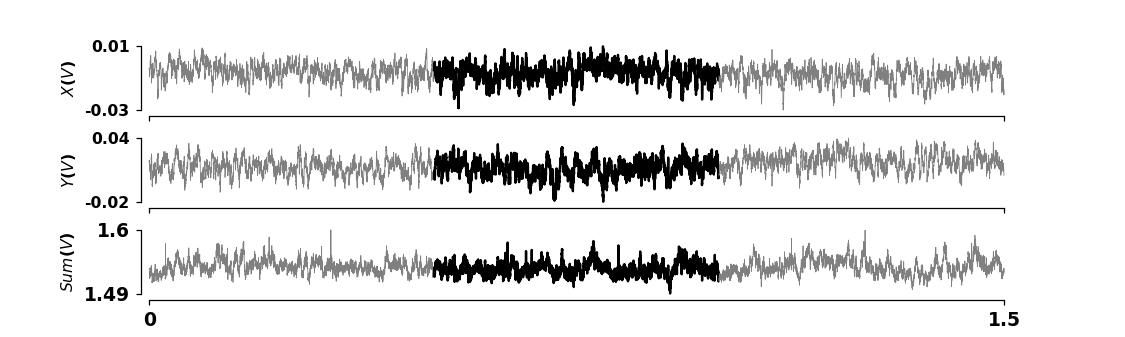

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator


In [6]:
%matplotlib notebook
subplots(figsize=[10,3])
subplot(311)
ax1=gca()
t0=0
dt=10e-5
ind=1
i=0
i1=0

times = t0+np.arange(0, len(x_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, x_data[ind][i1],color='gray',lw=0.5)
i2=1
times = t0+np.arange(0, len(x_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, x_data[ind][i2],color='k',ls='-')
i3=2
times = t0+np.arange(0, len(x_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, x_data[ind][i3],color='gray',ls='-',lw=0.5)


ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
    

ax1.set_ylabel(r"$X(V)$")
ax1.set_xticklabels([])
    
    
xrange=t0
factorx=0.01
    
ax1.set_xlim(0-factorx*xrange,t0+factorx*xrange)
ax1.set_xticks([0,t0])
ax1.spines['bottom'].set_bounds(0,t0)
    
yrange=np.max(x_data[ind][0:3])-np.min(x_data[ind][0:3])
factor=0.1
    
ax1.set_ylim(np.min(x_data[ind][0:3])-factor*yrange,np.max(x_data[ind][0:3])+factor*yrange)
ax1.spines['left'].set_bounds(np.min(x_data[ind][0:3]),np.max(x_data[ind][0:3]))
ax1.set_yticks([np.min(x_data[ind][0:3]),np.max(x_data[ind][0:3])])
ax1.set_yticklabels([round(np.min(x_data[ind][0:3]),2),round(np.max(x_data[ind][0:3]),2)])

######################################################################################################
#######################################################################################################


subplot(312)
ax2=gca()
t0=0
dt=10e-5
i=0
i1=0
times = t0+np.arange(0, len(y_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, y_data[ind][i1],color='gray',lw=0.5)
i2=1
times = t0+np.arange(0, len(y_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, y_data[ind][i2],color='k',ls='-')
i3=2
times = t0+np.arange(0, len(y_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, y_data[ind][i3],color='gray',ls='-',lw=0.5)


ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
    

ax2.set_ylabel(r"$Y(V)$")
ax2.set_xticklabels([])
    
    
xrange=t0
factorx=0.01
    
ax2.set_xlim(0-factorx*xrange,t0+factorx*xrange)
ax2.set_xticks([0,t0])
ax2.spines['bottom'].set_bounds(0,t0)
    
yrange=np.max(y_data[ind][0:3])-np.min(y_data[ind][0:3])
factor=0.1
    
ax2.set_ylim(np.min(y_data[ind][0:3])-factor*yrange,np.max(y_data[ind][0:3])+factor*yrange)
ax2.spines['left'].set_bounds(np.min(y_data[ind][0:3]),np.max(y_data[ind][0:3]))
ax2.set_yticks([np.min(y_data[ind][0:3]),np.max(y_data[ind][0:3])])
ax2.set_yticklabels([round(np.min(y_data[ind][0:3]),2),round(np.max(y_data[ind][0:3]),2)])


######################################################################################################
#######################################################################################################

subplot(313)
ax3=gca()
t0=0
dt=10e-5
i=0
i1=0
times = t0+np.arange(0, len(sum_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, sum_data[ind][i1],color='gray',lw=0.5)
i2=1
times = t0+np.arange(0, len(sum_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, sum_data[ind][i2],color='k',ls='-')
i3=2
times = t0+np.arange(0, len(sum_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, sum_data[ind][i3],color='gray',ls='-',lw=0.5)


ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
    

ax3.set_ylabel(r"$Sum(V)$")
ax3.set_xticklabels([0,round(t0,2)],fontsize=12)
    
    
xrange=t0
factorx=0.01
    
ax3.set_xlim(0-factorx*xrange,t0+factorx*xrange)
ax3.set_xticks([0,t0])
ax3.spines['bottom'].set_bounds(0,t0)
    
yrange=np.max(sum_data[ind][0:3])-np.min(sum_data[ind][0:3])
factor=0.1
    
ax3.set_ylim(np.min(sum_data[ind][0:3])-factor*yrange,np.max(sum_data[ind][0:3])+factor*yrange)
ax3.spines['left'].set_bounds(np.min(sum_data[ind][0:3]),np.max(sum_data[ind][0:3]))
ax3.set_yticks([np.min(sum_data[ind][0:3]),np.max(sum_data[ind][0:3])])
ax3.set_yticklabels([round(np.min(sum_data[ind][0:3]),2),round(np.max(sum_data[ind][0:3]),2)],fontsize=12)
ax3.set_xlabel(r"$t(s)$", fontsize=12)


savefig('images/Segments',dpi=300)
 

# PCA Plot

In [14]:
from sklearn import *

ncomp=10


model = decomposition.PCA(n_components=ncomp)
model.fit(data_X)
PCs1 = model.transform(data_X)

model2 = decomposition.PCA(n_components=ncomp)
model2.fit(data_Y)
PCs2 = model2.transform(data_Y)

model3 = decomposition.PCA(n_components=ncomp)
model3.fit(data_Sum)
PCs3 = model3.transform(data_Sum)


label0=unique_targets[0]
label1=unique_targets[1]
label2=unique_targets[2]
label3=unique_targets[3]
label4=unique_targets[4]
label5=unique_targets[5]

i0= np.where(labels==0)[0]
i1= np.where(labels==1)[0]
i2= np.where(labels==2)[0]
i3= np.where(labels==3)[0]
i4= np.where(labels==4)[0]
i5= np.where(labels==5)[0]



<IPython.core.display.Javascript object>


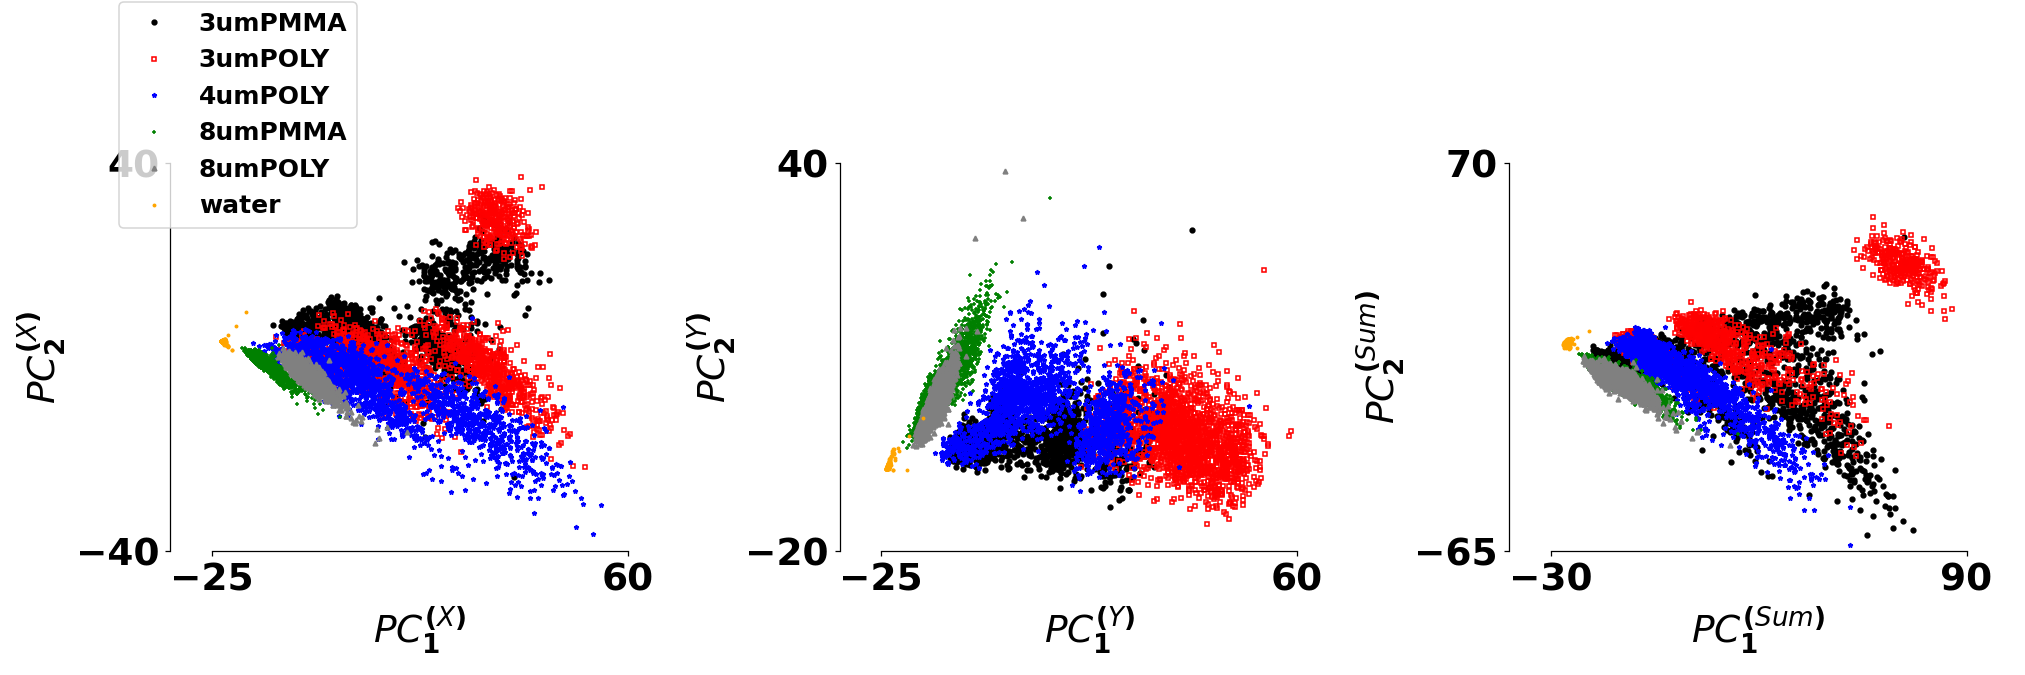

In [15]:
subplots(figsize=[18,6])
pc1 = 0
pc2 = 1
c=['k','r','b','g','gray','orange']
fs=24
fs1=24
fs2=16


subplot(131)
plot(PCs1[i0,pc1],PCs1[i0,pc2],'o',markersize=3,color=c[0],label=label0)
plot(PCs1[i1,pc1],PCs1[i1,pc2],'s',markersize=3,fillstyle='none', color=c[1],label=label1)
plot(PCs1[i2,pc1],PCs1[i2,pc2],'*',markersize=3,color=c[2],label=label2)
plot(PCs1[i3,pc1],PCs1[i3,pc2],'+',markersize=3,color=c[3],label=label3)
plot(PCs1[i4,pc1],PCs1[i4,pc2],'^',markersize=3,color=c[4],label=label4)
plot(PCs1[i5,pc1],PCs1[i5,pc2],'.',markersize=3,color=c[5],label=label5)
ax=gca()
ax.set_xlim([-25,60])
ax.set_xticks([-25,60])
ax.set_ylim([-20,40])
ax.set_yticks([-40,40])
xticks(fontsize=fs1)
yticks(fontsize=fs1)
xlabel(r"$PC^{(X)}_1$",fontsize=fs)
ylabel(r'$PC^{(X)}_2$',fontsize=fs)
legend(fontsize=fs2,bbox_to_anchor=(0.4, 0.8))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax.get_xlim()[0],ax.get_xlim()[1]]
xrange=ax.get_xlim()[1]-ax.get_xlim()[0]
ax.set_xlim(ax.get_xlim()[0]-factorx*xrange,ax.get_xlim()[1]+factorx*xrange)
ax.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])


subplot(132)
plot(PCs2[i0,pc1],PCs2[i0,pc2],'o',markersize=3,color=c[0],label=label0)
plot(PCs2[i1,pc1],PCs2[i1,pc2],'s',markersize=3,fillstyle='none', color=c[1],label=label1)
plot(PCs2[i2,pc1],PCs2[i2,pc2],'*',markersize=3,color=c[2],label=label2)
plot(PCs2[i3,pc1],PCs2[i3,pc2],'+',markersize=3,color=c[3],label=label3)
plot(PCs2[i4,pc1],PCs2[i4,pc2],'^',markersize=3,color=c[4],label=label4)
plot(PCs2[i5,pc1],PCs2[i5,pc2],'.',markersize=3,color=c[5],label=label5)
ax=gca()
ax.set_xlim([-25,60])
ax.set_xticks([-25,60])
ax.set_ylim([-20,40])
ax.set_yticks([-20,40])
xticks(fontsize=fs1)
yticks(fontsize=fs1)
xlabel(r"$PC^{(Y)}_1$",fontsize=fs)
ylabel(r'$PC^{(Y)}_2$',fontsize=fs)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax.get_xlim()[0],ax.get_xlim()[1]]
xrange=ax.get_xlim()[1]-ax.get_xlim()[0]
ax.set_xlim(ax.get_xlim()[0]-factorx*xrange,ax.get_xlim()[1]+factorx*xrange)
ax.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])


subplot(133)
plot(PCs3[i0,pc1],PCs3[i0,pc2],'o',markersize=3,color=c[0],label=label0)
plot(PCs3[i1,pc1],PCs3[i1,pc2],'s',markersize=3,fillstyle='none', color=c[1],label=label1)
plot(PCs3[i2,pc1],PCs3[i2,pc2],'*',markersize=3,color=c[2],label=label2)
plot(PCs3[i3,pc1],PCs3[i3,pc2],'+',markersize=3,color=c[3],label=label3)
plot(PCs3[i4,pc1],PCs3[i4,pc2],'^',markersize=3,color=c[4],label=label4)
plot(PCs3[i5,pc1],PCs3[i5,pc2],'.',markersize=3,color=c[5],label=label5)
ax=gca()
ax.set_xlim([-30,90])
ax.set_xticks([-30,90])
ax.set_ylim([-65,70])
ax.set_yticks([-65,70])
xticks(fontsize=fs1)
yticks(fontsize=fs1)
xlabel(r"$PC^{(Sum)}_1$",fontsize=fs)
ylabel(r'$PC^{(Sum)}_2$',fontsize=fs)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax.get_xlim()[0],ax.get_xlim()[1]]
xrange=ax.get_xlim()[1]-ax.get_xlim()[0]
ax.set_xlim(ax.get_xlim()[0]-factorx*xrange,ax.get_xlim()[1]+factorx*xrange)
ax.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])
tight_layout()
savefig('images/PCA',dpi=300)

# Plot Principal Components

<IPython.core.display.Javascript object>


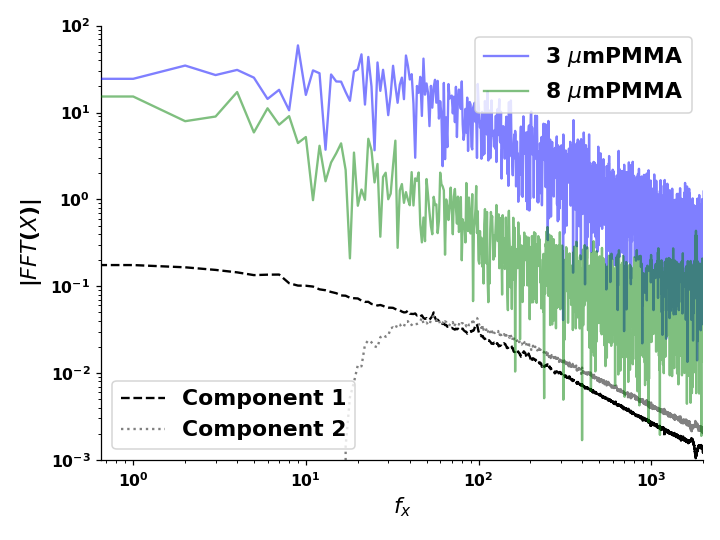

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


In [70]:
subplots()

ax=gca()

ax.plot(model.components_[0],color='k',ls='--',label='Component 1')
ax.plot(model.components_[1],color='gray',ls=':',label='Component 2')

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim((0,2000))
ax.set_ylim((0.001,100))
legend(loc=3,fontsize=14)

ax2 = ax.twinx()


i1 = 0
i2 = 300*20
ax2.plot(data_X[i1],color='b', alpha = 0.5, label=unique_targets1[labels[i1]])
ax2.plot(data_X[i2],color='g', alpha = 0.5, label=unique_targets1[labels[i2]])

ax2.set_yscale("log")
ax2.set_xscale("log")


ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.legend(loc=1,fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)


ax.set_xlabel("$f_x$", fontsize=14)
ax.set_ylabel("$|FFT(X)|$",fontsize=14)

tight_layout()

# Plot Explained Variance

<IPython.core.display.Javascript object>


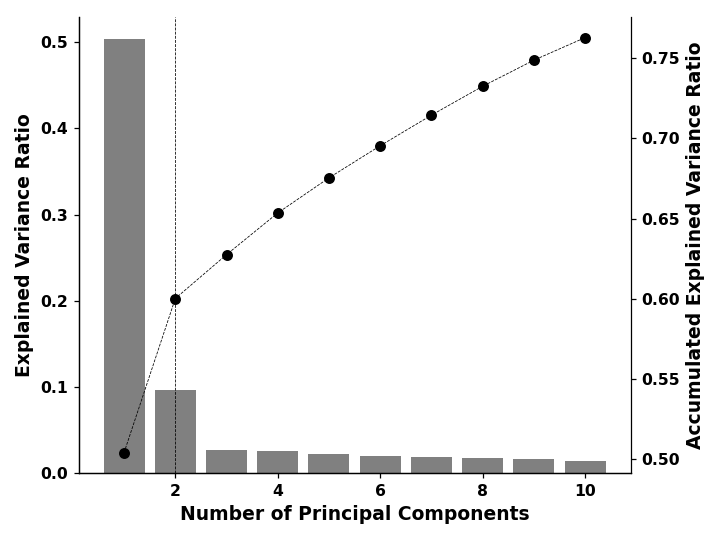

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: scipy.cumsum is deprecated and will be removed in SciPy 2.0.0, use numpy.cumsum instead
  del sys.path[0]


In [68]:
fs=12
subplots()
ax=gca()
ax.bar(range(1,ncomp+1),model.explained_variance_ratio_,color='grey')
ax.axvline(x=2,ls='--',lw=0.5,color='k')
ax.set_xlabel('Number of Principal Components',fontsize=fs)
ax.set_ylabel('Explained Variance Ratio',fontsize=fs)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2 = ax.twinx()

ax2.plot(range(1,ncomp+1),cumsum(model.explained_variance_ratio_),color='k',marker='o',ls='--',lw=0.5)
ax2.set_ylabel('Accumulated Explained Variance Ratio',fontsize=fs)
ax2.spines['top'].set_visible(False)
tight_layout()